In [1]:
print("""
FullName : Frank Evin Yami Ngassam
Student’s Number: 0232112159

Modelling and Analysis of Complex Networks
Assignment 9
Number of the dataset : 5
""")


FullName : Frank Evin Yami Ngassam
Student’s Number: 0232112159

Modelling and Analysis of Complex Networks
Assignment 9
Number of the dataset : 5



PACKAGES AND DATA LOADING

In [2]:
import networkx as nx
import urllib.request
import numpy as np
import matplotlib.pyplot as plt
import random
from itertools import combinations
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_auc_score, precision_score, roc_curve
import matplotlib.pyplot as plt

In [3]:
# Correct URLs pointing to the raw files on GitHub
facebook_url = "https://raw.githubusercontent.com/1250326/exercise_complex_network/master/Datasets/Group5/Facebook-Ego/686.edges"

# Download the Facebook-Ego network file
urllib.request.urlretrieve(facebook_url, "facebook.edges")

# Load the Facebook-Ego network as an undirected graph
facebook_network = nx.read_edgelist("facebook.edges", nodetype=int)



### STEP 1: LOAD THE FACEBOOK DATA SET AND CHECK THE NUMBER OF NODES AND EDGES

In [4]:

# Basic graph information
num_nodes = facebook_network.number_of_nodes()
num_edges = facebook_network.number_of_edges()

num_nodes, num_edges



(168, 1656)

### STEP 2: DATA PREPROCESSING

In [5]:
# Set random seed for reproducibility
random.seed(42)

# Calculate the number of edges to remove (10% of total edges)
num_test_edges = int(0.1 * num_edges)

# Randomly sample edges for the test set
test_edges = random.sample(list(facebook_network.edges), num_test_edges)

# Create a copy of the graph and remove the test edges
G_train = facebook_network.copy()
G_train.remove_edges_from(test_edges)

# Check the number of edges in the training graph
num_edges_train = G_train.number_of_edges()

num_test_edges, num_edges_train


(165, 1491)

In [6]:
# Generate all possible node pairs (non-edges) for negative sampling
all_possible_pairs = set(combinations(facebook_network.nodes, 2))
existing_edges = set(facebook_network.edges)
non_edges = all_possible_pairs - existing_edges

# Sample an equal number of negative samples as the test edges
negative_samples = random.sample(non_edges, num_test_edges)

# Combine test edges (positive samples) and negative samples for the test set
test_set = pd.DataFrame(test_edges + negative_samples, columns=["node1", "node2"])
test_set["label"] = [1] * len(test_edges) + [0] * len(negative_samples)

# Feature extraction: Jaccard coefficient and common neighbors
def extract_features(graph, edge_list):
    features = []
    for u, v in edge_list:
        # Jaccard coefficient
        jc = next(nx.jaccard_coefficient(graph, [(u, v)]), (u, v, 0))[2]
        # Number of common neighbors
        cn = len(list(nx.common_neighbors(graph, u, v)))
        features.append((u, v, jc, cn))
    return pd.DataFrame(features, columns=["node1", "node2", "jaccard", "common_neighbors"])

# Extract features for the test set
test_features = extract_features(G_train, test_set[["node1", "node2"]].values)
test_features["label"] = test_set["label"]

# Show sample of extracted features
test_features.head()



/var/folders/f2/9svl2vhs7zv85_7q56myyq5jr977fc/T/ipykernel_14867/3657722315.py:7: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  negative_samples = random.sample(non_edges, num_test_edges)


,node1,node2,jaccard,common_neighbors,label
0,856,765,0.200000,5,1
1,752,745,0.473684,27,1
2,819,835,0.210526,8,1
3,794,700,0.300000,3,1
4,764,843,0.206897,6,1


### STEP 3: MODEL TRAINING AND PREDICTION

In [ ]:
# Separate features and labels
X = test_features[["jaccard", "common_neighbors"]]
y = test_features["label"]

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Train a Logistic Regression model
model = LogisticRegression()
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)[:, 1]


### STEP 4: EVALUATION  OF METRICS

In [7]:

# Calculate evaluation metrics
accuracy = accuracy_score(y_test, y_pred)
auroc = roc_auc_score(y_test, y_pred_proba)
precision = precision_score(y_test, y_pred)

# Print metrics
print(f"Accuracy: {accuracy:.4f}")
print(f"AUROC: {auroc:.4f}")
print(f"Precision: {precision:.4f}")




Accuracy: 0.7374
AUROC: 0.8777
Precision: 0.8372


### STEP 5: ROC CURVE GRAPH

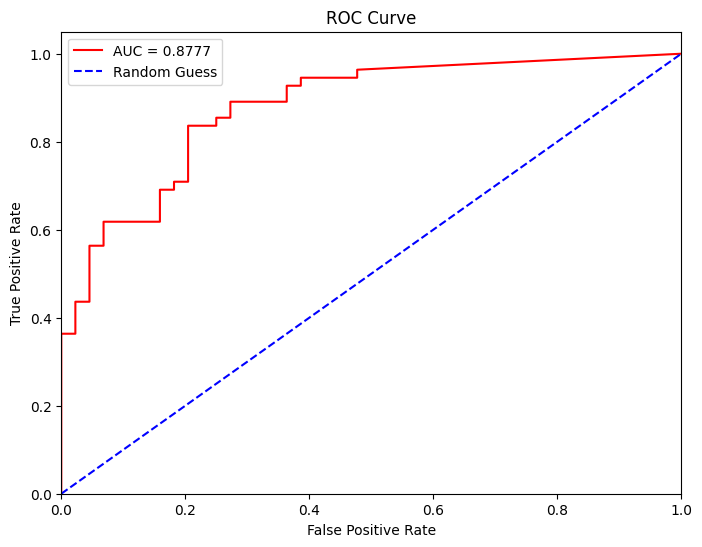

In [19]:
# Plot ROC curve
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color ='red', label=f"AUC = {auroc:.4f}")
plt.plot([0, 1], [0, 1], '--', label="Random Guess",color = 'blue')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()